In [106]:
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from tqdm.auto import tqdm
from torchvision.utils import make_grid

In [107]:
# custom libraries
root_main = os.getcwd()
os.chdir("..")
import TorchCommon as TC
os.chdir(root_main)

In [108]:
# main pyperparametrs
valid_size=0.2
batch_size=128
epochs=50
lr= 1e-3
nrm_mean=0.5
nrm_std=0.5
num_workers=0
root_ds = "D:\GitHub\pytorch-lab\Dataset" # dataset root
root_bm = "D:\GitHub\pytorch-lab\Best_Models" # best models root

In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [110]:
# transform
trans=transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((nrm_mean,) , (nrm_std,))
])

In [111]:
#load dataset
train_data=datasets.MNIST(root=root_ds,
                          train=True, transform=trans, download=True)

test_data=datasets.MNIST(root=root_ds,
                          train=False, transform=trans, download=True)

In [112]:
#sampler
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [113]:
#dataloader
train_loader=DataLoader(train_data, batch_size= batch_size, num_workers=num_workers, sampler=train_sampler)
valid_loader=DataLoader(train_data, batch_size= batch_size, num_workers=num_workers, sampler=valid_sampler)
test_loader =DataLoader(test_data,  batch_size= batch_size, num_workers=num_workers, shuffle=True)

In [114]:
def dense(num_in, num_out):
    return nn.Sequential(
        nn.Linear(num_in, num_out),
        nn.BatchNorm1d(num_out),
        nn.ReLU(inplace=True),
        )

In [115]:
def decoder(image_dim, num_hidden):
    return nn.Sequential(
        dense(image_dim, num_hidden),
        dense(num_hidden, num_hidden)
    )

In [116]:
def encoder(num_hidden, image_dim):
    return nn.Sequential(
        dense(num_hidden, num_hidden),
        dense(num_hidden, image_dim)
    )

In [117]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [118]:
class Net(nn.Module):
    def __init__(self, image_dim, num_hidden):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            decoder(image_dim, num_hidden),
            encoder(num_hidden, image_dim)
        )

    def forward(self, x):
        return self.net(torch.flatten(x, start_dim=1))

In [119]:
# instance of model
model=Net(784, 128).to(device)
# criterion
criterion = nn.MSELoss()
# optimizer
optimizer=optim.Adam(model.parameters(), lr=lr)

############################################################
###### Epoch 1 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 1.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.89


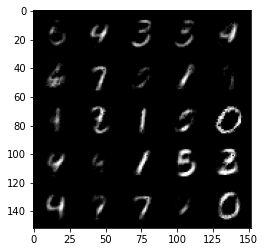

############################################################
###### Epoch 2 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.89


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.88


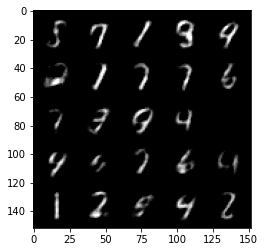

############################################################
###### Epoch 3 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.88


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.87


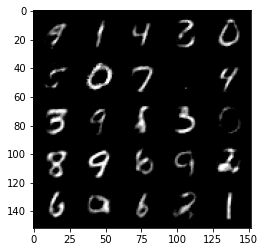

############################################################
###### Epoch 4 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.87


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.87


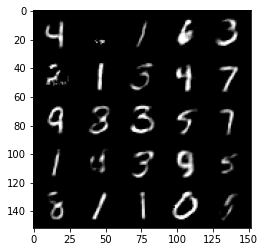

############################################################
###### Epoch 5 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.87


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.86


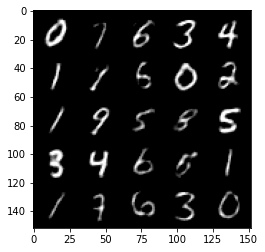

############################################################
###### Epoch 6 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.86


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.86


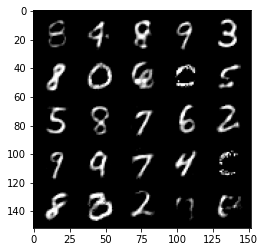

############################################################
###### Epoch 7 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.86


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.86


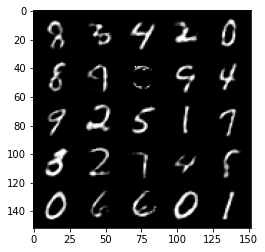

############################################################
###### Epoch 8 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.86


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.85


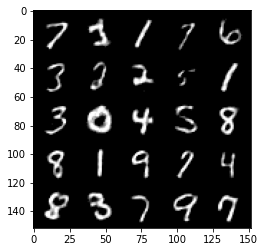

############################################################
###### Epoch 9 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.86


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.85


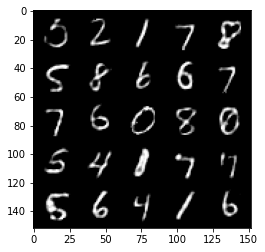

############################################################
###### Epoch 10 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.86


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.85


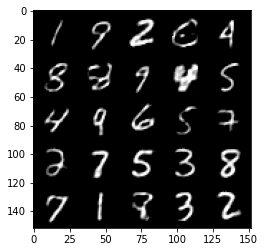

############################################################
###### Epoch 11 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.85


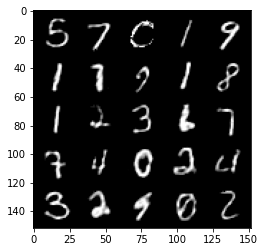

############################################################
###### Epoch 12 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.85


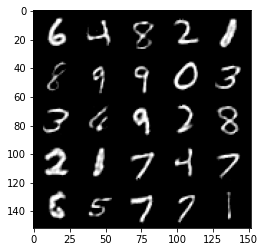

############################################################
###### Epoch 13 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.85


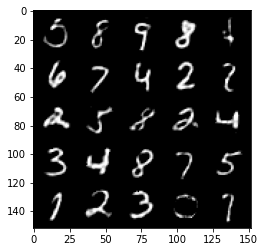

############################################################
###### Epoch 14 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.85


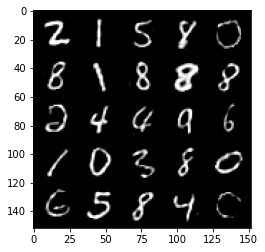

############################################################
###### Epoch 15 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.85


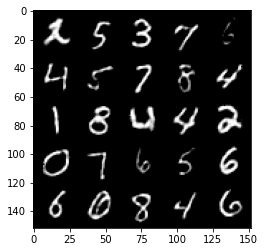

############################################################
###### Epoch 16 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.85


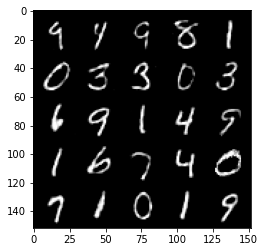

############################################################
###### Epoch 17 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.85


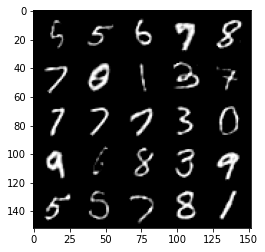

############################################################
###### Epoch 18 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.84


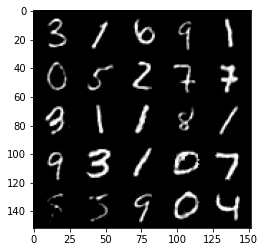

############################################################
###### Epoch 19 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.84


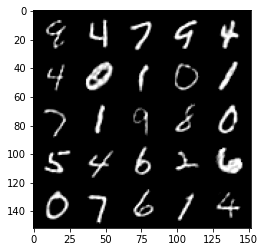

############################################################
###### Epoch 20 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

Loss_Train: 0.85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss_Valid: 0.84


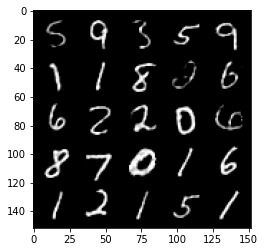

############################################################
###### Epoch 21 #############################################
############################################################


  0%|          | 0/375 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [120]:
for epoch in range(1,epochs+1):
    # !!!
    print(60 * "#")
    print(6 * "#" + " Epoch " + str(epoch) + " " + 45 * "#")
    print(60 * "#")

    # loss/acc all training data
    loss_train, loss_valid = 0, 0

    # Set mode on "train mode"
    model.train()

    for iter_train, (image, _) in enumerate(tqdm(train_loader), 1):
        # Transfer training data on desired device
        image = image.to(device)

        # "require_grad" have accumulating property
        optimizer.zero_grad()

        # Feed training data to model
        y_hat = model(image)

        # average of mini-batch loss & mini-batch accuracy
        loss = criterion(y_hat, torch.flatten(image, start_dim=1))

        # summation of all mini-batches loss (loss of all data)
        # & summation of all mini-batches accuracy (accuracy of all data)
        loss_train += loss.item() * image.size(0)

        # Gradient
        loss.backward()

        # Update all parameters that embedded on "optimizer".
        # Update all parameters that "require_grad" is true.
        optimizer.step()

    # average loss/accuracy of all training data
    loss_train /= len(train_loader.sampler)

    # Display average loss/accuracy of all training data
    print("Loss_Train: {:.2f}".format(loss_train))

    model.eval()
    for iter_valid, (image, _) in enumerate(valid_loader, 1):
        # in evaluation phase, we don't need to use gradient because of lack of updating.
        with torch.no_grad():
            # Transfer training data on desired device
            image = image.to(device)

            # Feed training data to model
            y_hat = model(image)

            # average of mini-batch loss & mini-batch accuracy
            loss = criterion(y_hat, torch.flatten(image, start_dim=1))

            # summation of all mini-batches loss (loss of all data)
            # & summation of all mini-batches accuracy (accuracy of all data)
            loss_valid += loss.item() * image.size(0)

            # for show
            if iter_valid == 1 :
                image_show = image

    # average loss/accuracy of all training data
    loss_valid /= len(valid_loader.sampler)

    # Display average loss/accuracy of all training data
    print("Loss_Valid: {:.2f}".format(loss_valid))

    show_tensor_images(model(image_show))

# Result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


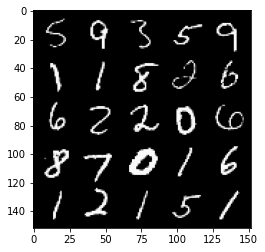

In [122]:
# one mini-batch of validation data
show_tensor_images((image_show))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


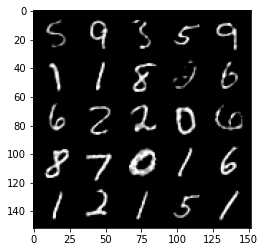

In [121]:
# output of AE for one mini-batch of validation data
show_tensor_images(model(image_show))